# Prediccion precio de la Papa Serie univariada

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [2]:
papa = pd.read_excel(r'C:\Users\jorgi\OneDrive\Documents\hec\MATERIA PRIMA.xlsx',
                    parse_dates=["Fecha"])

In [3]:
precios = papa[['Fecha','Vr. Unitario','Cantidad','Nombre Concepto','Beneficiario Nombre','Ciudad Nombre']]

In [4]:
precio_R12=precios[precios['Nombre Concepto']=='C-PAPA R12 ' ]
precio_pp = precios[precios['Nombre Concepto']=='C-PAPA FRESCA- PRODUCTO AGROPECUARIO']
precio = pd.concat([precio_R12,precio_pp])

                   

In [5]:
precio_promedio_diario = precio.groupby(['Fecha']).mean()

Text(0, 0.5, 'Precio de la Papa R-12 por kilo en COP')

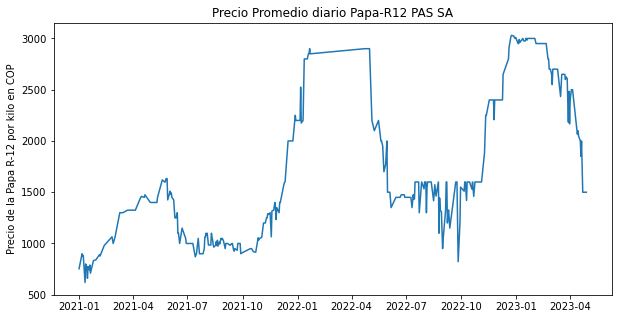

In [6]:
f = plt.figure(figsize=(10,5))
plt.plot(precio_promedio_diario.index,precio_promedio_diario['Vr. Unitario'])
plt.title('Precio Promedio diario Papa-R12 PAS SA')
plt.ylabel('Precio de la Papa R-12 por kilo en COP')


### Separacion de la base

In [7]:
train = precio_promedio_diario.iloc[:138,0:1].values # va hasta el 31 de diciembre de 2021


In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)

#### Time steps y Base de entrenamiento

In [9]:
X_train = []
y_train = []
for i in range(60, 138):
    '''el rango empieza en 60, por que se necesitan al menos 60 datos para hacer la primera prediccion
    teniendo en cuenta obivamente que el time step que se eligio es 60, ya que se puede elegir otro
    el rango va hasta la ultima observacion'''
    X_train.append(train[i-60:i, 0]) #recuerda que esto es filas,columnas
    ''' de esa manera el primer valor de i seria 60, entonces agarra para el index
    del dato 0 hasta el 59, ya que va de 60 en 60, de esa manera se agrupan en corchetes de 60
    tal y como se ve abajo, tambien hay que notar que para cada valor de y son los 60 anteriores
    por ende se repiten valores, pero es intuitivamente normal, pues para predecir el primer precio
    pues se necesitan las primeras 60, para el segundo de la 1 a la 61'''
    y_train.append(train[i, 0])
    ''' En cambio este empieza desde el dato numero 60 que seria el index 59, o el pprimero
    del segundo corchete de X_train'''
X_train, y_train = np.array(X_train), np.array(y_train) # hay que volverlos array

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Red neuronal

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [12]:
# input layer
regressor = Sequential()
#LSTM Layers
#layer 1
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
#Layer 2
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
#Layer 3
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
#Layer 4
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.2))
#Output layer
regressor.add(Dense(units = 1))

In [13]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [14]:
regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
3/3 [==============================] - 19s 117ms/step - loss: 0.1142
Epoch 2/50
3/3 [==============================] - 0s 102ms/step - loss: 0.0415
Epoch 3/50
3/3 [==============================] - 0s 107ms/step - loss: 0.0363
Epoch 4/50
3/3 [==============================] - 0s 109ms/step - loss: 0.0211
Epoch 5/50
3/3 [==============================] - 0s 101ms/step - loss: 0.0267
Epoch 6/50
3/3 [==============================] - 0s 102ms/step - loss: 0.0213
Epoch 7/50
3/3 [==============================] - 0s 106ms/step - loss: 0.0194
Epoch 8/50
3/3 [==============================] - 0s 106ms/step - loss: 0.0164
Epoch 9/50
3/3 [==============================] - 0s 105ms/step - loss: 0.0208
Epoch 10/50
3/3 [==============================] - 0s 109ms/step - loss: 0.0197
Epoch 11/50
3/3 [==============================] - 0s 115ms/step - loss: 0.0196
Epoch 12/50
3/3 [==============================] - 0s 110ms/step - loss: 0.0168
Epoch 13/50
3/3 [==============================]

#### X_test


In [15]:
test=precio_promedio_diario[138:163] # va hasta desde el 1 de enero hasta el 22 de enero

In [17]:
dataset = precio_promedio_diario['Vr. Unitario'][0:163]
inputs = dataset[len(dataset) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
# solo se necesitan los datos de inputs, pero se deben organizar como antes, agrupandolos de a 60 para hacer cada prediccion
for i in range(60, 85):
    #va desde el 60 hasta el 60, desde 60 dias antes del primer dia de enero, hasta 60
    #asi hasta llegar a 80 ya que los datos de enero son 20
    X_test.append(inputs[i-60:i, 0])

In [18]:
X_test = np.array(X_test)
# lo mismo que el X_train, debe resultar un array 3D, con numero de obs, numero de time stamps y de variables
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
precio_predicho = regressor.predict(X_test)


1/1 [==============================] - 4s 4s/step


In [19]:
precio_predicho = sc.inverse_transform(precio_predicho)

In [20]:
precio_predicho

array([[1481.2148],
       [1539.5386],
       [1621.998 ],
       [1729.5322],
       [1859.4858],
       [2005.7792],
       [2159.6877],
       [2316.8057],
       [2472.015 ],
       [2619.9563],
       [2755.3857],
       [2873.729 ],
       [2971.5989],
       [3054.7961],
       [3121.3599],
       [3169.5671],
       [3212.3396],
       [3261.648 ],
       [3325.659 ],
       [3407.49  ],
       [3505.378 ],
       [3615.    ],
       [3729.8032],
       [3843.6333],
       [3949.6633]], dtype=float32)

### Resultados

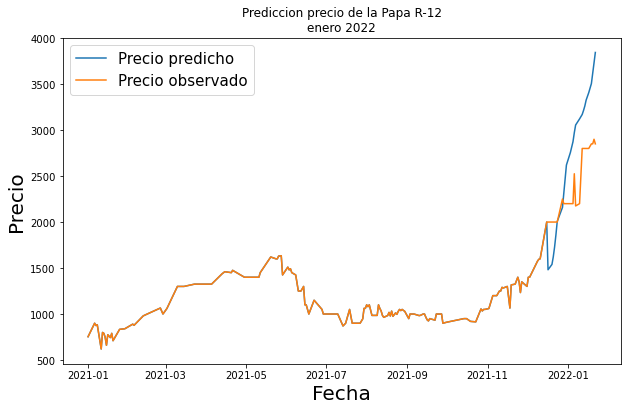

In [21]:
a = np.append(sc.inverse_transform(train), precio_predicho).reshape(163,1)
b = np.append(sc.inverse_transform(train), test.iloc[:,0:1]).reshape(163,1)
fig = plt.figure(figsize=(10,6))
plt.plot(precio_promedio_diario[:162].index,a[:-1],label="Precio predicho")
plt.plot(precio_promedio_diario[:162].index,b[:-1], label="Precio observado")
plt.title('''Prediccion precio de la Papa R-12
enero 2022''')
plt.xlabel("Fecha",fontsize=(20))
plt.ylabel("Precio",fontsize=(20))
plt.legend(fontsize=(15))

In [22]:
Resultados = pd.DataFrame(dataset)
Resultados['Precios predichos'] = a